In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import boxcox
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.preprocessing import OneHotEncoder

In [2]:
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", None)
pd.set_option("precision", 3)
sns.set_context("talk") # talk context is good for RISE presentations
%pylab inline
%config InlineBackend.figure_formats = ['retina']

Populating the interactive namespace from numpy and matplotlib


# **1. Read the data saved from data_cleaning.ipynb**

In [3]:
fn = '../data/clean_data/us_accidents.csv'
df = pd.read_csv(fn)

In [4]:
df.head(3)

,severity,start_lat,start_lng,distance(mi),side,state,temperature(f),humidity(%),pressure(in),visibility(mi),wind_speed(mph),precipitation(in),amenity,bump,crossing,give_way,junction,no_exit,railway,roundabout,station,stop,traffic_calming,traffic_signal,duration,start_time_dayname,start_time_daypart,season,pressure(in)_na,state_freq,zip_freq,precipitation(in)_na,visibility(mi)_na,temperature(f)_na,humidity(%)_na,wind_speed(mph)_na,wind_direction,weather_clear,weather_fair,weather_cloudy,weather_windy,weather_rain,weather_snow,weather_obscuration,weather_sand,weather_na
0,3,39.88,-84.06,0.01,R,OH,36.90,91.00,29.69,10.00,10.30,0.02,False,False,False,False,False,False,False,False,False,False,False,False,314,monday,early_morning,spring,False,0.60,0.05,False,False,False,False,True,calm,False,False,False,False,True,False,False,False,False
1,2,39.94,-82.80,0.01,L,OH,37.90,100.00,29.66,10.00,10.30,0.00,False,False,False,False,False,False,False,False,False,False,False,False,30,monday,early_morning,spring,False,0.60,0.04,False,False,False,False,True,calm,False,False,False,False,True,False,False,False,False
2,2,39.06,-84.06,0.01,R,OH,36.00,100.00,29.67,10.00,3.50,0.02,False,False,False,False,False,False,False,False,False,False,False,True,30,monday,early_morning,spring,False,0.60,0.02,True,False,False,False,False,sw,False,False,True,False,False,False,False,False,False


### Make sure there are no missing values

In [5]:
missing = df.isnull().sum().reset_index()
missing.columns = ['Feature', 'Missing_Num']
missing['Missing_Percent(%)'] = 100*missing['Missing_Num']/df.shape[0]
missing.loc[missing['Missing_Percent(%)']>0,:].sort_values(by=['Missing_Num'], ascending=False)

,Feature,Missing_Num,Missing_Percent(%)


# **2. Delete the point of interest with less samples, which are highly imbalanced**
1. Calculate the percentage of "true" for each point of interest feature
2. Determine a threshold using the 75th percentile of all these percentage values of point of interest features  
3. Remove the point of interest features whose percentage of "true" is smaller than the threshold


In [6]:
# remove highly imbalanced features  
feat_name = ['amenity', 'bump', 'crossing', 'give_way', 'junction', 'no_exit', 
            'railway', 'roundabout', 'station', 'stop', 'traffic_calming',
             'traffic_signal'
            ]
ratio = [100*sum(df[feat_name[i]] == 1)/df.shape[0] for i, e in enumerate(feat_name)]
t = pd.DataFrame({'feat_name': feat_name, 'ratio(%)': ratio})
print(t)
thresh = np.percentile(ratio, 75)
drop_columns = list(t['feat_name'][t['ratio(%)'] < thresh])
print('-------------------')
print(drop_columns)
# drop 
df.drop(labels=drop_columns, axis=1, inplace=True)

          feat_name  ratio(%)
0           amenity      1.17
1              bump      0.02
2          crossing      8.21
3          give_way      0.31
4          junction      8.02
5           no_exit      0.14
6           railway      0.91
7        roundabout      0.01
8           station      2.04
9              stop      1.71
10  traffic_calming      0.05
11   traffic_signal     17.21
-------------------
['amenity', 'bump', 'give_way', 'no_exit', 'railway', 'roundabout', 'station', 'stop', 'traffic_calming']


# **3. Delete the added columns that impute "true" for missing values, they were found not to be useful**

In [7]:
# drop imputed features for nans
columns = df.columns
drop_feat = [c for c in columns if '_na' in c]
print(drop_feat)
mask = df[drop_feat[0]] == 1

for i, d_f in enumerate(drop_feat):
    mask = mask & (df[d_f] == 1)

df.drop(index=df[mask].index, inplace=True)

['pressure(in)_na', 'precipitation(in)_na', 'visibility(mi)_na', 'temperature(f)_na', 'humidity(%)_na', 'wind_speed(mph)_na', 'weather_na']


In [8]:
columns = df.columns
drop_feat = [c for c in columns if '_na' in c]
df.drop(drop_feat, axis=1, inplace=True)

# **4. Apply boxcox transformation for the continuous features with largely  skewed data**

In [9]:

df['visibility(mi)_bc'] =  boxcox(df['visibility(mi)'].apply(lambda x: x+1),lmbda=0)
df['pressure(in)_bc'] =  boxcox(df['pressure(in)'].apply(lambda x: x+1),lmbda=4)
df['wind_speed(mph)_bc'] =  boxcox(df['wind_speed(mph)'].apply(lambda x: x+1),lmbda=0.02)
df['precipitation(in)_bc'] =  boxcox(df['precipitation(in)'].apply(lambda x: x+1),lmbda=-10)
df.drop(['visibility(mi)', 'pressure(in)', 'wind_speed(mph)', 'precipitation(in)'], axis=1, inplace=True)


# **5. Apply one hot encoding for categorical features**

In [10]:
# one hot encoding
df_cat_1 = df[['state', 'side', 'wind_direction',
           'start_time_dayname', 'start_time_daypart',
            'season']] 

df_cat_2 = df[['crossing', 'junction', 'traffic_signal', 
               'weather_clear', 'weather_fair', 'weather_cloudy',
               'weather_windy', 'weather_rain', 'weather_snow',
               'weather_obscuration', 'weather_sand'               
               ]].astype(int)

df_cont = df[['start_lat', 'start_lng',
              'temperature(f)', 'humidity(%)', 
              'pressure(in)_bc', 'visibility(mi)_bc', 'wind_speed(mph)_bc',
              'precipitation(in)_bc']]


ohe = OneHotEncoder(sparse=False)
ohe.fit(df_cat_1)
df_cat_1_ohe = ohe.transform(df_cat_1)

columns = ohe.get_feature_names(['state', 'side', 'wind_direction',
           'start_time_dayname', 'start_time_daypart',
            'season'])
df_cat_1_ohe = pd.DataFrame(df_cat_1_ohe, columns=columns, index=df_cat_1.index, dtype=int)

df_cat_ohe = pd.concat([df_cat_1_ohe, df_cat_2], axis=1)


In [11]:
df_cat_ohe.head(5)

,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,side_L,side_R,wind_direction_calm,wind_direction_e,wind_direction_n,wind_direction_na,wind_direction_ne,wind_direction_nw,wind_direction_s,wind_direction_se,wind_direction_sw,wind_direction_var,wind_direction_w,start_time_dayname_friday,start_time_dayname_monday,start_time_dayname_saturday,start_time_dayname_sunday,start_time_dayname_thursday,start_time_dayname_tuesday,start_time_dayname_wednesday,start_time_daypart_afternoon,start_time_daypart_early_morning,start_time_daypart_evening,start_time_daypart_late_night,start_time_daypart_morning,start_time_daypart_night,season_fall,season_spring,season_summer,season_winter,crossing,junction,traffic_signal,weather_clear,weather_fair,weather_cloudy,weather_windy,weather_rain,weather_snow,weather_obscuration,weather_sand
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0


# **6. Save a csv file for preprocessed data** 

In [12]:
df_preprocessed = pd.concat([df_cont, df_cat_ohe, df['severity']], axis=1)
# fn = '../data/clean_data/us_accidents_preprocessed.csv'
# df_preprocessed.to_csv(fn, index=False)

In [13]:
df_preprocessed.head(3)

,start_lat,start_lng,temperature(f),humidity(%),pressure(in)_bc,visibility(mi)_bc,wind_speed(mph)_bc,precipitation(in)_bc,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,side_L,side_R,wind_direction_calm,wind_direction_e,wind_direction_n,wind_direction_na,wind_direction_ne,wind_direction_nw,wind_direction_s,wind_direction_se,wind_direction_sw,wind_direction_var,wind_direction_w,start_time_dayname_friday,start_time_dayname_monday,start_time_dayname_saturday,start_time_dayname_sunday,start_time_dayname_thursday,start_time_dayname_tuesday,start_time_dayname_wednesday,start_time_daypart_afternoon,start_time_daypart_early_morning,start_time_daypart_evening,start_time_daypart_late_night,start_time_daypart_morning,start_time_daypart_night,season_fall,season_spring,season_summer,season_winter,crossing,junction,traffic_signal,weather_clear,weather_fair,weather_cloudy,weather_windy,weather_rain,weather_snow,weather_obscuration,weather_sand,severity
0,39.88,-84.06,36.90,91.00,"221,782.40",2.40,2.49,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,3
1,39.94,-82.80,37.90,100.00,"220,916.48",2.40,2.49,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,2
2,39.06,-84.06,36.00,100.00,"221,204.84",2.40,1.53,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,2


In [14]:
df_preprocessed.shape

(4160192, 99)

In [15]:
%reset_selective -f df_cat_ohe, df_cont, df

# **7. Generate a figure showing class imbalance**

In [16]:
# define the dataset location
data = df_preprocessed.values
# split into input and output elements
X, y = data[:, :-2], data[:, -1]
# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
per = []
for k,v in counter.items():
    t_per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, t_per))
    per.append(t_per)

Class=2, n=1055836 (25.380%)
Class=1, n=2954227 (71.012%)
Class=0, n=29068 (0.699%)
Class=3, n=121061 (2.910%)


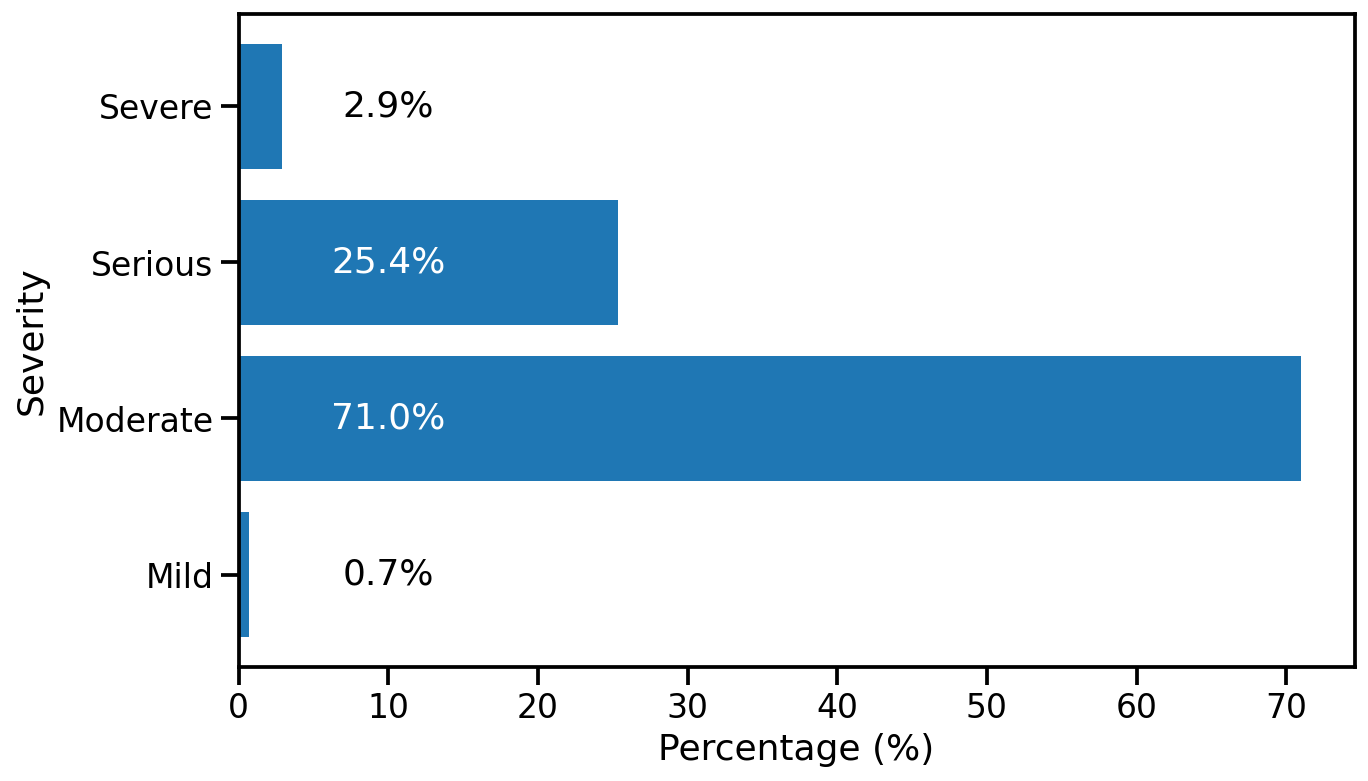

In [17]:
# plot the distribution
fontsize = 18
plt.subplots(figsize=(10, 6))
ax = plt.barh(y=list(counter.keys())[::-1], width=per[::-1], height=0.8)
plt.yticks(range(0,4), ['Mild', 'Moderate', 'Serious', 'Severe'])
plt.ylabel('Severity')
plt.xlabel('Percentage (%)')

plt.text(10, 2, '{}%'.format(round(per[0], 1)), horizontalalignment='center',
         verticalalignment='center',  fontdict={'fontsize':fontsize, 'color':'w'})
plt.text(10, 1, '{}%'.format(round(per[1], 1)), horizontalalignment='center',
         verticalalignment='center',  fontdict={'fontsize':fontsize, 'color':'w'})
plt.text(10, 3, '{}%'.format(round(per[3], 1)), horizontalalignment='center',
         verticalalignment='center',  fontdict={'fontsize':fontsize, 'color':'k'})
plt.text(10, 0, '{}%'.format(round(per[2], 1)), horizontalalignment='center',
         verticalalignment='center',  fontdict={'fontsize':fontsize, 'color':'k'});

# plt.savefig('../figures/case_prctage.svg', dpi=300,  bbox_inches='tight', facecolor="white")